# Implementation of a Simple Multilayer Perceptron in Theano

**EE514: Data Analysis and Machine Learning**

[Kevin McGuinness](http://www.eeng.dcu.ie/~mcguinne/), School of Electronic Engineering, Dublin City University

---

In Theano, we compose a computational graph that maps inputs to outputs. Theano can then automatically compute the gradients wrt the parameters on this graph. Under the hood, Theano factors out common computations, so you effectively get the dynamic programming part of backprop for free. All you need to do is specify the forward computations.

## Import packages and define some utility functions

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# make plots prettier
import seaborn as sns
sns.set_style('white')

In [ ]:
import theano
import theano.tensor as T

In [ ]:
def plot_dataset(X, y):
    figure(figsize=(7,7))
    scatter(X[:, 0], X[:, 1], s=100, c=y, edgecolor='k')
    show()

def plot_decision_function(df, X, y, levels=(0.5,)):
    
    # Find span of data
    x0_min, x1_min = np.min(X, axis=0)
    x0_max, x1_max = np.max(X, axis=0)
    x0_range = x0_max - x0_min
    x1_range = x1_max - x1_min
    
    # Add small buffer around data
    x0_min = x0_min - 0.1 * x0_range
    x0_max = x0_max + 0.1 * x0_range
    x1_min = x1_min - 0.1 * x1_range
    x1_max = x1_max + 0.1 * x1_range
    
    # Generate linearly spaced points
    x0 = np.linspace(x0_min, x0_max, 100)
    x1 = np.linspace(x1_min, x1_max, 100)
    
    # Generate meshgrid
    X0, X1 = np.meshgrid(x0, x1)
    
    # Evaluate decision function for all points on the grid
    Y = df(np.c_[X0.ravel(), X1.ravel()]).reshape(X0.shape)
    
    # Plot the decision function
    figure(figsize=(7,7))
    contour(X0, X1, Y, levels=levels, 
            linestyles=['dashed', 'solid', 'dashed'],
            linewidths=1,
            colors='k')
    
    # Plot the data
    scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')

## Model specification

Our model will have 2 input units (2D input), 30 hidden units, and 1 output unit (the prediction)

In [ ]:
n_input = 2
n_hidden = 30
n_output = 1

We will use a learning rate of 0.2 and a regularization penalty $\lambda = 10^{-6}$ 

In [ ]:
regularization_penalty = 1e-6
lr = 0.2

First we specify placeholders for the input and outputs of the network. The input is a 2D "design" matrix $X$, which will have examples on the *rows* and features in the columns. The output $y$ is a vector that will contain the $\{0, 1\}$ training targets.

In [ ]:
# these are the data matrices
X = T.dmatrix('X')
y = T.dmatrix('y')

Now we create shared variables for the paramaters of the network. We have two mappings, one from input to hidden, and one from hidden to output. This gives us two sets of parameters: a matrix of weights $W_1$ and vector of biases $b_1$ to go from input to hidden, and a matrix of weights $W_2$ and vector of biases $b_2$ to go from hidden to outputs.

In [ ]:
# parameters
np.random.seed(42)
W1 = theano.shared(np.random.randn(n_input, n_hidden), 'W1')
b1 = theano.shared(np.zeros(n_hidden), 'b1')
W2 = theano.shared(np.random.randn(n_hidden, n_output), 'W2')
b2 = theano.shared(np.zeros(n_output), 'b2')
parameters = [W1, b1, W2, b2]

Next we create the compute graph for the forward pass of the network. Note that we use $XW+b$ instead of $Wx+b$ beacuse we want to compute the outputs for a full batch of examples in one go, and our examples are on the rows of $X$.

In [ ]:
# input to hidden
z1 = T.dot(X, W1) + b1
h1 = T.nnet.relu(z1)

# hidden to output
z2 = T.dot(h1, W2) + b2
prediction = T.nnet.sigmoid(z2)

Next we specify the loss function. We use a combination of a data loss, cross entropy, and an $L_2$ regularizer.

$$
    \mathcal{L} = \mathcal{L}_{\text{data}} + \lambda (\|W_1\|^2 + \|W_2\|^2)
$$

Note that there is no regularizer placed on the biases.

In [ ]:
# cross entropy data loss
data_loss = T.nnet.binary_crossentropy(prediction, y).mean()

# L2 regularizer (only on the weights, not the biases)
regularizer = (W1**2).sum() + (W2**2).sum()

# total loss
loss = data_loss + regularization_penalty * regularizer

## Infer the gradient compute graph

Now we use Theano automatic differenciation magic to generate compute graphs for the gradients wrt the parameters. Theano will automatically factor out common computations in the graph, which effectively gives us backprop for free.

In [ ]:
# automatically create compute graphs for gradients (autodiff) 
gradients = T.grad(loss, parameters)

## Specify the SGD update step

To train the network, we need to specify how to take a gradient descent step. To do this we first create a list describing how to update each of the free parameters of the network (weights and biases). This is a list of pairs (parameter, update), where update is a theano expression for how to update the corresponding parameter. This is where we encode the gradient descent update rule:

$$
\theta_{t+1} = \theta_{t} - \lambda \nabla_{\theta} \mathcal{L}
$$

Once we have this we can specify a train function that takes as input the examples $X$ and targets $y$, produces a loss value, and performs the specified parameter updates.

In [ ]:
# create a list of gradient updates
# this is a list of pairs (parameter, update)
updates = [(theta, theta - lr * dtheta) 
           for theta, dtheta 
           in zip(parameters, gradients)]

# training function: takes a single gradient descent step
train = theano.function(
    inputs=[X, y],
    outputs=loss,
    updates=updates)

## Specify a prediction function

Finally, we need to create a function that maps inputs to predictions, so that we could actually use our model to make predictions on unseen data. 

In [ ]:
# decision function
# theano.function turns a compute graph into a callable function
predict = theano.function(inputs=[X], outputs=prediction)

## Generate a dataset

Let's create a simple dataset that is not linearly separable...

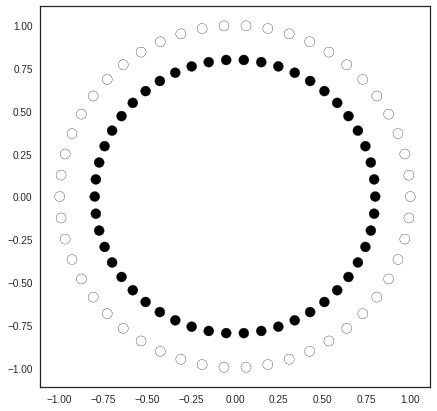

In [ ]:
from sklearn.datasets import make_circles
X, y = make_circles(shuffle=True, random_state=42)
plot_dataset(X, y)

## Train the network

We can now train our network. Here we are using full gradient descent. This is fine, since there are only 100 training examples. The train function can just as easily be used for mini-batch stochastic gradient descent by dividing the training examples up into batches and calling train on each batch.

In [ ]:
nb_epoch = 800
losses = []
for i in range(nb_epoch):
    loss = train(X, y[:,np.newaxis])
    losses.append(loss)

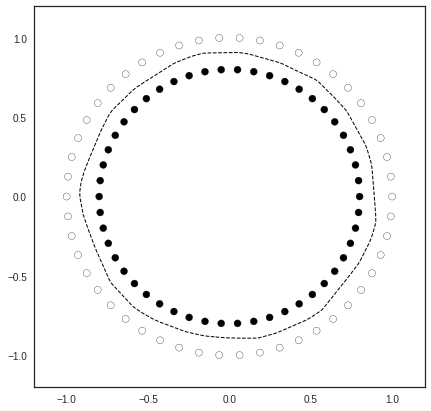

In [ ]:
plot_decision_function(predict, X, y, levels=(0.0, 0.5, 1.0))

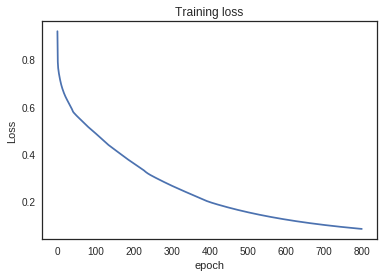

In [ ]:
plot(losses)
title('Training loss')
xlabel('epoch')
ylabel('Loss')
show()

## Visualize the learned weights

You can get the learned parameters calling ``.get_value()`` on the shared variables for the parameters. Here we plot the learned weights in the $W_1$ matrix using an image and a diverging color palette.

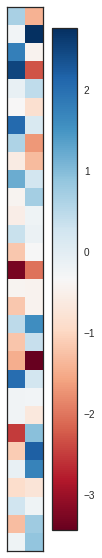

In [ ]:
figure(figsize=(3,10))
imshow(W1.get_value().T, interpolation='nearest', cmap=cm.RdBu)
colorbar()
ax = gca()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

## Exercises

- Modify the training loop to plot the decision function every 50 iterations and see how the decision function evolves. Remember to re-initialize the parameters before training by running the from **Model Specification** on.